In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import to_datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
import time


In [3]:
# load dataset
df = read_csv("db_oferta_groupdata.csv", delimiter=';', header=0, encoding="utf-8")
df['data'] = to_datetime(df['data'], format='%Y-%m-%d')


df.head(15)

,data,energia(mwmed)
0,2016-01-01,17205
1,2016-02-01,17435
2,2016-03-01,14569
3,2016-04-01,14897
4,2016-05-01,15772
5,2016-06-01,17035
6,2016-07-01,16639
7,2016-08-01,15064
8,2016-09-01,14889
9,2016-10-01,14127


<class 'pandas.core.series.Series'>
RangeIndex: 90 entries, 0 to 89
Series name: energia(mwmed)
Non-Null Count  Dtype
--------------  -----
90 non-null     int64
dtypes: int64(1)
memory usage: 848.0 bytes


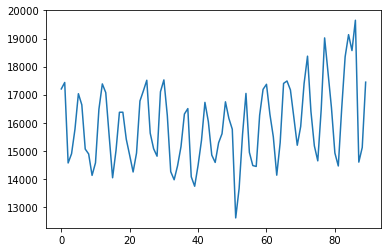

In [4]:
energia_series = df['energia(mwmed)'].reindex(df.index)
energia_series.info()
energia_series.head()

# line plot
energia_series.plot()
pyplot.show()

# Experimental Test Setup

In [5]:
# split data into train and test
X = energia_series.values
train, test = X[0:-18], X[-18:]

RMSE: 1874.475


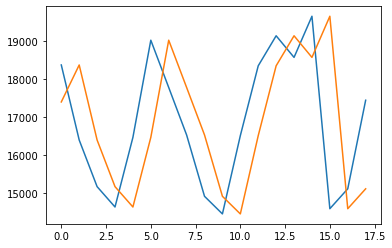

In [6]:
# walk-forward validation

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction...
    predictions.append(history[-1])
    # observation
    history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

# Transform Time Series to Stationary

In [7]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# transform data to be stationary
raw_values = energia_series.values
diff_values = difference(raw_values, 1)


# Transform Time Series to Supervised Learning

In [8]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
 df = DataFrame(data)
 columns = [df.shift(i) for i in range(1, lag+1)]
 columns.append(df)
 df = concat(columns, axis=1)
 df.fillna(0, inplace=True)
 return df
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [14]:
# split data into train and test-sets
train, test = supervised_values[0:-18], supervised_values[-18:]

# Transform Time Series to Scale

In [15]:
# scale train and test data to [-1, 1]
def scale(train, test):
 # fit scaler
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaler = scaler.fit(train)
 # transform train
 train = train.reshape(train.shape[0], train.shape[1])
 train_scaled = scaler.transform(train)
 # transform test
 test = test.reshape(test.shape[0], test.shape[1])
 test_scaled = scaler.transform(test)
 return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
 new_row = [x for x in X] + [value]
 array = numpy.array(new_row)
 array = array.reshape(1, len(array))
 inverted = scaler.inverse_transform(array)
 return inverted[0, -1]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# LSTM Model Development

In [24]:
from keras.optimizers import RMSprop

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))  # Output layer
    model.compile(loss='mean_squared_error', optimizer='RMSprop')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
 X = X.reshape(1, 1, len(X))
 yhat = model.predict(X, batch_size=batch_size)
 return yhat[0,0]

71/71 [==============================] - 0s 2ms/step - loss: 0.1402


71/71 [==============================] - 0s 2ms/step - loss: 0.1296


71/71 [==============================] - 0s 2ms/step - loss: 0.1268


71/71 [==============================] - 0s 2ms/step - loss: 0.1076


71/71 [==============================] - 0s 2ms/step - loss: 0.0892


71/71 [==============================] - 0s 2ms/step - loss: 0.0987


71/71 [==============================] - 0s 2ms/step - loss: 0.0971


71/71 [==============================] - 0s 2ms/step - loss: 0.0818


71/71 [==============================] - 0s 2ms/step - loss: 0.0818


71/71 [==============================] - 0s 2ms/step - loss: 0.0911


71/71 [==============================] - 0s 2ms/step - loss: 0.1206


71/71 [==============================] - 0s 2ms/step - loss: 0.0989


1/1 [==============================] - 0s 28ms/step
Month=1, Predicted=18496.368171, Expected=18372.000000
1/1 [==============================] - 0s 22ms/step
Month=2, Predicted=16106.609266, Expected=16402.000000
1/1 [==============================] - 0s 35ms/step
Month=3, Predicted=14566.251919, Expected=15178.000000
1/1 [==============================] - 0s 29ms/step
Month=4, Predicted=13441.165436, Expected=14644.000000
1/1 [==============================] - 0s 24ms/step
Month=5, Predicted=16184.741072, Expected=16471.000000
1/1 [==============================] - 0s 26ms/step
Month=6, Predicted=19184.540031, Expected=19022.000000
1/1 [==============================] - 0s 24ms/step
Month=7, Predicted=17488.466295, Expected=17781.000000
1/1 [==============================] - 0s 27ms/step
Month=8, Predicted=15688.278693, Expected=16534.000000
1/1 [==============================] - 0s 18ms/step
Month=9, Predicted=13657.908367, Expected=14924.000000
1/1 [==============================] 

71/71 [==============================] - 0s 2ms/step - loss: 0.0964


71/71 [==============================] - 0s 2ms/step - loss: 0.0890


71/71 [==============================] - 0s 2ms/step - loss: 0.0797


71/71 [==============================] - 0s 2ms/step - loss: 0.0755


71/71 [==============================] - 0s 2ms/step - loss: 0.0729


71/71 [==============================] - 0s 2ms/step - loss: 0.0753


71/71 [==============================] - 0s 2ms/step - loss: 0.0759


71/71 [==============================] - 0s 2ms/step - loss: 0.0769


71/71 [==============================] - 0s 3ms/step - loss: 0.0822


71/71 [==============================] - 0s 2ms/step - loss: 0.0986


71/71 [==============================] - 0s 2ms/step - loss: 0.0992


71/71 [==============================] - 0s 2ms/step - loss: 0.0935


1/1 [==============================] - 0s 35ms/step
Month=1, Predicted=18806.017212, Expected=18372.000000
1/1 [==============================] - 0s 61ms/step
Month=2, Predicted=15892.804235, Expected=16402.000000
1/1 [==============================] - 0s 69ms/step
Month=3, Predicted=14720.202168, Expected=15178.000000
1/1 [==============================] - 0s 35ms/step
Month=4, Predicted=14323.454998, Expected=14644.000000
1/1 [==============================] - 0s 61ms/step
Month=5, Predicted=17232.016338, Expected=16471.000000
1/1 [==============================] - 0s 28ms/step
Month=6, Predicted=20351.315041, Expected=19022.000000
1/1 [==============================] - 0s 24ms/step
Month=7, Predicted=17251.393792, Expected=17781.000000
1/1 [==============================] - 0s 24ms/step
Month=8, Predicted=14996.827138, Expected=16534.000000
1/1 [==============================] - 0s 30ms/step
Month=9, Predicted=13739.902693, Expected=14924.000000
1/1 [==============================] 

71/71 [==============================] - 0s 2ms/step - loss: 0.0920


71/71 [==============================] - 0s 2ms/step - loss: 0.0826


71/71 [==============================] - 0s 3ms/step - loss: 0.0861


71/71 [==============================] - 0s 2ms/step - loss: 0.0847


71/71 [==============================] - 0s 2ms/step - loss: 0.0796


71/71 [==============================] - 0s 2ms/step - loss: 0.0794


71/71 [==============================] - 0s 2ms/step - loss: 0.0817


71/71 [==============================] - 0s 2ms/step - loss: 0.0829


71/71 [==============================] - 0s 2ms/step - loss: 0.0845


71/71 [==============================] - 0s 2ms/step - loss: 0.1190


71/71 [==============================] - 0s 2ms/step - loss: 0.0835


71/71 [==============================] - 0s 2ms/step - loss: 0.0836


1/1 [==============================] - 0s 32ms/step
Month=1, Predicted=19012.295844, Expected=18372.000000
1/1 [==============================] - 0s 30ms/step
Month=2, Predicted=16691.498476, Expected=16402.000000
1/1 [==============================] - 0s 31ms/step
Month=3, Predicted=14003.844729, Expected=15178.000000
1/1 [==============================] - 0s 32ms/step
Month=4, Predicted=13773.037242, Expected=14644.000000
1/1 [==============================] - 0s 32ms/step
Month=5, Predicted=17154.463550, Expected=16471.000000
1/1 [==============================] - 0s 33ms/step
Month=6, Predicted=20276.693858, Expected=19022.000000
1/1 [==============================] - 0s 30ms/step
Month=7, Predicted=18098.983450, Expected=17781.000000
1/1 [==============================] - 0s 32ms/step
Month=8, Predicted=15258.831786, Expected=16534.000000
1/1 [==============================] - 0s 26ms/step
Month=9, Predicted=15126.944769, Expected=14924.000000
1/1 [==============================] 

71/71 [==============================] - 0s 2ms/step - loss: 0.0945


71/71 [==============================] - 0s 2ms/step - loss: 0.0806


71/71 [==============================] - 0s 2ms/step - loss: 0.0753


71/71 [==============================] - 0s 2ms/step - loss: 0.0735


71/71 [==============================] - 0s 4ms/step - loss: 0.0745


71/71 [==============================] - 0s 2ms/step - loss: 0.0786


71/71 [==============================] - 0s 2ms/step - loss: 0.0850


71/71 [==============================] - 0s 2ms/step - loss: 0.0873


71/71 [==============================] - 0s 2ms/step - loss: 0.0856


71/71 [==============================] - 0s 2ms/step - loss: 0.0852


71/71 [==============================] - 0s 2ms/step - loss: 0.0864


1/1 [==============================] - 0s 26ms/step
Month=1, Predicted=19270.991220, Expected=18372.000000
1/1 [==============================] - 0s 58ms/step
Month=2, Predicted=16355.934856, Expected=16402.000000
1/1 [==============================] - 0s 27ms/step
Month=3, Predicted=14715.016838, Expected=15178.000000
1/1 [==============================] - 0s 16ms/step
Month=4, Predicted=14398.981661, Expected=14644.000000
1/1 [==============================] - 0s 32ms/step
Month=5, Predicted=17412.800278, Expected=16471.000000
1/1 [==============================] - 0s 21ms/step
Month=6, Predicted=20319.251382, Expected=19022.000000
1/1 [==============================] - 0s 29ms/step
Month=7, Predicted=18083.481426, Expected=17781.000000
1/1 [==============================] - 0s 74ms/step
Month=8, Predicted=15845.139152, Expected=16534.000000
1/1 [==============================] - 0s 44ms/step
Month=9, Predicted=14180.001822, Expected=14924.000000
1/1 [==============================] 

71/71 [==============================] - 0s 2ms/step - loss: 0.1026


71/71 [==============================] - 0s 2ms/step - loss: 0.0946


71/71 [==============================] - 0s 2ms/step - loss: 0.0928


71/71 [==============================] - 0s 2ms/step - loss: 0.0900


71/71 [==============================] - 0s 2ms/step - loss: 0.0771


71/71 [==============================] - 0s 3ms/step - loss: 0.0867


71/71 [==============================] - 0s 2ms/step - loss: 0.0807


71/71 [==============================] - 0s 2ms/step - loss: 0.0783


71/71 [==============================] - 0s 2ms/step - loss: 0.0701


71/71 [==============================] - 0s 2ms/step - loss: 0.0629


71/71 [==============================] - 0s 2ms/step - loss: 0.0667


71/71 [==============================] - 0s 2ms/step - loss: 0.0668


1/1 [==============================] - 0s 24ms/step
Month=1, Predicted=19253.300407, Expected=18372.000000
1/1 [==============================] - 0s 26ms/step
Month=2, Predicted=16260.155517, Expected=16402.000000
1/1 [==============================] - 0s 24ms/step
Month=3, Predicted=14919.027686, Expected=15178.000000
1/1 [==============================] - 0s 24ms/step
Month=4, Predicted=14575.732775, Expected=14644.000000
1/1 [==============================] - 0s 31ms/step
Month=5, Predicted=16349.452039, Expected=16471.000000
1/1 [==============================] - 0s 26ms/step
Month=6, Predicted=19811.899215, Expected=19022.000000
1/1 [==============================] - 0s 34ms/step
Month=7, Predicted=17994.840113, Expected=17781.000000
1/1 [==============================] - 0s 31ms/step
Month=8, Predicted=16043.560022, Expected=16534.000000
1/1 [==============================] - 0s 28ms/step
Month=9, Predicted=14594.123185, Expected=14924.000000
1/1 [==============================] 

71/71 [==============================] - 0s 2ms/step - loss: 0.1015


71/71 [==============================] - 0s 2ms/step - loss: 0.0980


71/71 [==============================] - 0s 2ms/step - loss: 0.0988


71/71 [==============================] - 0s 1ms/step - loss: 0.0928


71/71 [==============================] - 0s 2ms/step - loss: 0.0833


71/71 [==============================] - 0s 2ms/step - loss: 0.0820


71/71 [==============================] - 0s 2ms/step - loss: 0.0827


71/71 [==============================] - 0s 2ms/step - loss: 0.0932


71/71 [==============================] - 0s 2ms/step - loss: 0.1188


71/71 [==============================] - 0s 2ms/step - loss: 0.0989


71/71 [==============================] - 0s 2ms/step - loss: 0.0963


71/71 [==============================] - 0s 2ms/step - loss: 0.0873


1/1 [==============================] - 0s 26ms/step
Month=1, Predicted=19324.272851, Expected=18372.000000
1/1 [==============================] - 0s 27ms/step
Month=2, Predicted=16333.388674, Expected=16402.000000
1/1 [==============================] - 0s 32ms/step
Month=3, Predicted=14582.066674, Expected=15178.000000
1/1 [==============================] - 0s 25ms/step
Month=4, Predicted=14051.362616, Expected=14644.000000
1/1 [==============================] - 0s 23ms/step
Month=5, Predicted=16941.329146, Expected=16471.000000
1/1 [==============================] - 0s 21ms/step
Month=6, Predicted=20988.107586, Expected=19022.000000
1/1 [==============================] - 0s 19ms/step
Month=7, Predicted=18501.789339, Expected=17781.000000
1/1 [==============================] - 0s 26ms/step
Month=8, Predicted=15816.645949, Expected=16534.000000
1/1 [==============================] - 0s 25ms/step
Month=9, Predicted=13842.296592, Expected=14924.000000
1/1 [==============================] 

71/71 [==============================] - 0s 2ms/step - loss: 0.0828


71/71 [==============================] - 0s 2ms/step - loss: 0.0845


71/71 [==============================] - 0s 2ms/step - loss: 0.0820


71/71 [==============================] - 0s 2ms/step - loss: 0.0828


71/71 [==============================] - 0s 2ms/step - loss: 0.0810


71/71 [==============================] - 0s 2ms/step - loss: 0.0856


71/71 [==============================] - 0s 1ms/step - loss: 0.0953


71/71 [==============================] - 0s 2ms/step - loss: 0.1514


71/71 [==============================] - 0s 3ms/step - loss: 0.0845


71/71 [==============================] - 0s 3ms/step - loss: 0.0776


71/71 [==============================] - 0s 2ms/step - loss: 0.0783


71/71 [==============================] - 0s 2ms/step - loss: 0.0774


1/1 [==============================] - 0s 28ms/step
Month=1, Predicted=19100.193934, Expected=18372.000000
1/1 [==============================] - 0s 29ms/step
Month=2, Predicted=16001.839209, Expected=16402.000000
1/1 [==============================] - 0s 33ms/step
Month=3, Predicted=14333.623971, Expected=15178.000000
1/1 [==============================] - 0s 39ms/step
Month=4, Predicted=14398.859613, Expected=14644.000000
1/1 [==============================] - 0s 39ms/step
Month=5, Predicted=17312.709760, Expected=16471.000000
1/1 [==============================] - 0s 22ms/step
Month=6, Predicted=20261.133563, Expected=19022.000000
1/1 [==============================] - 0s 32ms/step
Month=7, Predicted=17951.998628, Expected=17781.000000
1/1 [==============================] - 0s 31ms/step
Month=8, Predicted=15546.338114, Expected=16534.000000
1/1 [==============================] - 0s 30ms/step
Month=9, Predicted=13998.615705, Expected=14924.000000
1/1 [==============================] 

71/71 [==============================] - 0s 2ms/step - loss: 0.1046


71/71 [==============================] - 0s 2ms/step - loss: 0.0981


71/71 [==============================] - 0s 2ms/step - loss: 0.0949


71/71 [==============================] - 0s 2ms/step - loss: 0.0954


71/71 [==============================] - 0s 2ms/step - loss: 0.0937


71/71 [==============================] - 0s 2ms/step - loss: 0.0911


71/71 [==============================] - 0s 2ms/step - loss: 0.0879


71/71 [==============================] - 0s 2ms/step - loss: 0.0852


71/71 [==============================] - 0s 2ms/step - loss: 0.0825


71/71 [==============================] - 0s 2ms/step - loss: 0.0792


71/71 [==============================] - 0s 2ms/step - loss: 0.0765


1/1 [==============================] - 0s 31ms/step
Month=1, Predicted=19421.311482, Expected=18372.000000
1/1 [==============================] - 0s 32ms/step
Month=2, Predicted=16511.236133, Expected=16402.000000
1/1 [==============================] - 0s 20ms/step
Month=3, Predicted=14800.082230, Expected=15178.000000
1/1 [==============================] - 0s 23ms/step
Month=4, Predicted=14052.785853, Expected=14644.000000
1/1 [==============================] - 0s 32ms/step
Month=5, Predicted=17596.284526, Expected=16471.000000
1/1 [==============================] - 0s 28ms/step
Month=6, Predicted=20204.728447, Expected=19022.000000
1/1 [==============================] - 0s 27ms/step
Month=7, Predicted=18096.673568, Expected=17781.000000
1/1 [==============================] - 0s 27ms/step
Month=8, Predicted=15803.446513, Expected=16534.000000
1/1 [==============================] - 0s 23ms/step
Month=9, Predicted=13965.053207, Expected=14924.000000
1/1 [==============================] 

71/71 [==============================] - 0s 2ms/step - loss: 0.0880


71/71 [==============================] - 0s 2ms/step - loss: 0.0794


71/71 [==============================] - 0s 2ms/step - loss: 0.0734


71/71 [==============================] - 0s 2ms/step - loss: 0.0760


71/71 [==============================] - 0s 2ms/step - loss: 0.0829


71/71 [==============================] - 0s 3ms/step - loss: 0.0865


71/71 [==============================] - 0s 2ms/step - loss: 0.0870


71/71 [==============================] - 0s 2ms/step - loss: 0.0871


71/71 [==============================] - 0s 2ms/step - loss: 0.0824


71/71 [==============================] - 0s 2ms/step - loss: 0.0812


71/71 [==============================] - 0s 1ms/step - loss: 0.0812


71/71 [==============================] - 0s 2ms/step - loss: 0.0828


1/1 [==============================] - 0s 32ms/step
Month=1, Predicted=19023.932704, Expected=18372.000000
1/1 [==============================] - 0s 25ms/step
Month=2, Predicted=16074.656319, Expected=16402.000000
1/1 [==============================] - 0s 34ms/step
Month=3, Predicted=14556.776399, Expected=15178.000000
1/1 [==============================] - 0s 29ms/step
Month=4, Predicted=14354.211455, Expected=14644.000000
1/1 [==============================] - 0s 24ms/step
Month=5, Predicted=17248.130251, Expected=16471.000000
1/1 [==============================] - 0s 32ms/step
Month=6, Predicted=19897.458490, Expected=19022.000000
1/1 [==============================] - 0s 20ms/step
Month=7, Predicted=17777.896784, Expected=17781.000000
1/1 [==============================] - 0s 32ms/step
Month=8, Predicted=15219.076971, Expected=16534.000000
1/1 [==============================] - 0s 32ms/step
Month=9, Predicted=14530.490076, Expected=14924.000000
1/1 [==============================] 

71/71 [==============================] - 0s 2ms/step - loss: 0.0869


71/71 [==============================] - 0s 2ms/step - loss: 0.1065


71/71 [==============================] - 0s 2ms/step - loss: 0.0986


71/71 [==============================] - 0s 2ms/step - loss: 0.0936


71/71 [==============================] - 0s 2ms/step - loss: 0.0870


71/71 [==============================] - 0s 2ms/step - loss: 0.0876


71/71 [==============================] - 0s 2ms/step - loss: 0.0905


71/71 [==============================] - 0s 2ms/step - loss: 0.0904


71/71 [==============================] - 0s 2ms/step - loss: 0.0916


71/71 [==============================] - 0s 2ms/step - loss: 0.0939


71/71 [==============================] - 0s 2ms/step - loss: 0.0793


71/71 [==============================] - 0s 2ms/step - loss: 0.0632


1/1 [==============================] - 0s 19ms/step
Month=1, Predicted=18926.570126, Expected=18372.000000
1/1 [==============================] - 0s 17ms/step
Month=2, Predicted=15832.916985, Expected=16402.000000
1/1 [==============================] - 0s 22ms/step
Month=3, Predicted=14335.158325, Expected=15178.000000
1/1 [==============================] - 0s 17ms/step
Month=4, Predicted=14621.685596, Expected=14644.000000
1/1 [==============================] - 0s 15ms/step
Month=5, Predicted=17225.853076, Expected=16471.000000
1/1 [==============================] - 0s 14ms/step
Month=6, Predicted=21068.617824, Expected=19022.000000
1/1 [==============================] - 0s 16ms/step
Month=7, Predicted=17534.294233, Expected=17781.000000
1/1 [==============================] - 0s 15ms/step
Month=8, Predicted=15465.843644, Expected=16534.000000
1/1 [==============================] - 0s 15ms/step
Month=9, Predicted=14099.331888, Expected=14924.000000
1/1 [==============================] 

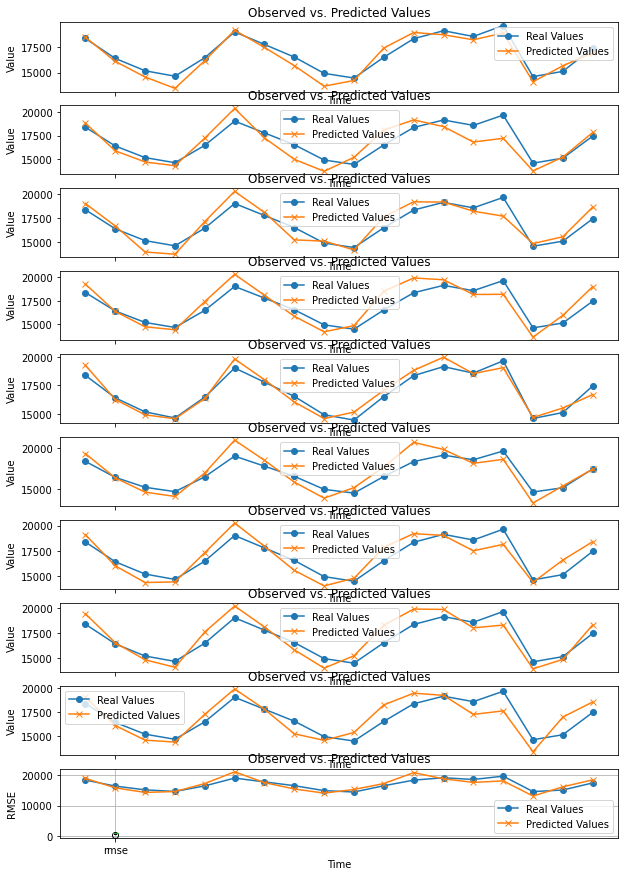

In [25]:
from keras.optimizers import RMSprop

#measure code time
start_time = time.time()

# repeat experiment
repeats = 10
error_scores = list()
R2_scores = list()

# Create a grid of subplots
fig, axes = plt.subplots(nrows=repeats, ncols=1, figsize=(10, 15), sharex=True)

for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 1500, 5)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)-i) # Update the interval here
        # store forecast
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]
        print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
    
    
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-18:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
    # Calculate R-squared
    r2 = r2_score(raw_values[-18:], predictions)
    print('%d) R-squared: %.3f' % (r+1, r2))
    R2_scores.append(r2)

    # Plot predicted vs. real values in the subplot
    ax = axes[r]
    ax.plot(raw_values[-18:], label='Real Values', marker='o')
    ax.plot(predictions, label='Predicted Values', marker='x')
    ax.set_ylabel('Value')
    ax.set_title('Experiment {}'.format(r + 1))
    # Set labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title('Observed vs. Predicted Values')
    ax.legend()
    

#measure code time
end_time = time.time()
print('Time taken: {:.2f} seconds'.format(end_time - start_time))

# summarize results
results = DataFrame()
results['rmse'] = error_scores
results['R2'] = R2_scores
results_rmse = results['rmse']
print(results.describe())


# Box plot of RMSE
results.boxplot(column='rmse')
pyplot.ylabel('RMSE')
pyplot.show()

1.Adjust Hyperparameters:

Number of Neurons: Experiment with increasing or decreasing the number of neurons in the LSTM layer. Start with a small number (e.g., 4 or 8) and gradually increase it to see if it improves the model's ability to capture patterns.

Batch Size: Adjust the batch size used during training. Smaller batch sizes can help the model converge faster, but larger batch sizes might improve generalization.

Number of Epochs: Reduce the number of epochs. Sometimes, models can start overfitting after training for too long. Try training for fewer epochs and monitor the performance.

2.Change Activation Function:

Instead of using the default activation function, ReLU, try using different activation functions like tanh or sigmoid in the LSTM layer. Different activation functions can help the model learn different types of patterns.

3.Increase Sequence Length:

Increase the sequence length used for training. This will allow the model to consider more historical data for making predictions, potentially capturing longer-term patterns.

4.Try Different Optimizers:

Experiment with different optimizers such as RMSprop or SGD. Optimizers can influence how quickly the model converges and the quality of the solutions it finds.

5.Add Dropout:

Implement dropout layers after the LSTM layer to prevent overfitting. A dropout layer randomly drops a fraction of the connections during training, forcing the model to be more robust.

6.Learning Rate Scheduling:

Implement a learning rate scheduler. This can help fine-tune the learning rate during training to find a better balance between convergence speed and accuracy.

7.Use a Simpler Model:

Consider using a simpler architecture, like a basic feedforward neural network or an Autoregressive Integrated Moving Average (ARIMA) model. Sometimes, a complex model might not be necessary for simple time series data.

8.Data Preprocessing:

Explore different methods of differencing or transformation. Sometimes, simple preprocessing techniques like taking the logarithm of the data or applying seasonal differencing can improve the stationarity of the series.

9.More Data:

Collect more historical data if possible. Having a longer historical context can help the model learn better patterns.

10.Evaluate and Iterate:

After implementing each change, evaluate the model's performance using metrics like RMSE, MAE, and R-squared. Make changes one at a time and assess their impact before combining multiple changes.